# Restarting to implement learnings from experimentation for a final product

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import os
import glob
from tqdm.notebook import tqdm
from IPython.display import HTML, Image as ipython_image
import pickle
import gc
# From resnetvideo
from torchvision.models.video.resnet import Bottleneck, BasicBlock, Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D
from typing import Any, Callable, List, Optional, Sequence, Tuple, Type, Union
from torch import Tensor

import matplotlib.pylab
matplotlib.pylab.rcParams['figure.dpi'] = 200

# Preparation for the Dataset class

VIDEO_DIR = 'simvid'

def sort_folders(folders, split_idx):
    idx = [int(x.split("_")[split_idx]) for x in folders]
    folders = [x for _, x in sorted(zip(idx, folders))]
    idx.sort()
    return folders, idx

video_dirs, video_idx = sort_folders(os.listdir(VIDEO_DIR), 1)

random.seed(123)

file_df = pd.DataFrame({
    "video_no": video_idx,
    "video_dirs": video_dirs,
    "train": random.choices([0, 1], weights = [0.2, 0.8], k=len(video_dirs))
})

class CustomVideoDataset(Dataset):
    def __init__(self, df, parent_dir, transform_img):
        self.parent_dir = parent_dir
        self.videos = df.video_dirs.tolist()
        self.video_numbers = df.video_no.tolist()
        self.transform_img = transform_img
    def sort_files(self, files, split_idx):
        """
        Sort files based on the third element in the image file name within the video directory.
        Videos are named like so [blob|claim]_frame_##.png. Sorting is done on the third element, or index 2.
        """
        files = [os.path.splitext(x)[0] for x in files]
        idx = [int(x.split("_")[split_idx]) for x in files]
        files = [x for _, x in sorted(zip(idx, files))]
        idx.sort()
        return files, idx
    def __len__(self):
        return len(self.videos)
    def __getitem__(self, idx):
        # Get frames from video set
        video_dir = os.path.join(self.parent_dir, self.videos[idx])
        video_id  = self.video_numbers[idx]
        # Get blob files
        blob_frame_files = glob.glob("blob*", root_dir=video_dir)
        blob_frame_files, _ = self.sort_files(blob_frame_files, 2)
        blob_frame_files = [os.path.join(video_dir, x + '.png') for x in blob_frame_files]
        blob_frame_images = [self.transform_img(Image.open(x)) for x in blob_frame_files]
        blob_tensor = torch.stack(blob_frame_images, dim=1)
        # Get claims data files
        claims_data_files = glob.glob("claims_data_*.png", root_dir=video_dir)
        claims_data_files, _ = self.sort_files(claims_data_files, 2)
        claims_data_files = [os.path.join(video_dir, x + '.png') for x in claims_data_files]
        claims_data_images = [self.transform_img(Image.open(x)) for x in claims_data_files]
        claims_final_state = claims_data_images[-1]
        claims_tensor = torch.stack(claims_data_images, dim=1)
        # Get final claims state
        return blob_frame_images, blob_tensor, claims_data_images, claims_tensor, claims_final_state, video_id

def model_fit(net, train_dataloader, index, output_dir, epochs):
    model_save = f'videoresnet{index}.pt'
    epoch_loss_save = f'epoch-loss-{index}.pkl'
    outputs_save = f'output-tensors-{index}.pkl'
    items_dir = os.path.join(output_dir, f'outputs-{index}')
    # Downsample function -- just a 2-kernel convolution with weight set to 1 and bias removed.
    downsample = nn.Conv2d(1, 1, 2, 2, bias=False)
    downsample.weight = torch.nn.Parameter(torch.ones_like(downsample.weight))
    if not os.path.isdir(items_dir):
        os.mkdir(items_dir)
    if not model_save in os.listdir(items_dir):
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        train_loss = []
        epoch_loss = []
        outputs = []
        for epoch in tqdm(range(epochs)):
            for _, data in enumerate(train_dataloader):
                _, blob_tensor, _, _, final_state, video_id = data
                blob_tensor = blob_tensor.to("cuda")
                # Downsample to [1,1,1,64,64]
                final_state_downsampled = downsample(final_state)
                final_state_downsampled = torch.unsqueeze(final_state_downsampled,0) # Match dim of output [1,1,1,64,64]
                final_state = final_state.to("cuda")
                final_state_downsampled = final_state_downsampled.to("cuda")
                optimizer.zero_grad()
                res = net(blob_tensor)
                output_tensor, stem_result, encoding, encoding_prediction, upsample, output_video, avgpool = res
                loss_tensor = nn.MSELoss()(
                    output_tensor, final_state
                )
                encoding_loss_tensor = nn.MSELoss()(
                    encoding_prediction, final_state_downsampled
                )
                # Average losses
                loss_tensor = (loss_tensor + encoding_loss_tensor) / 2
                loss_tensor.backward()
                train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
                optimizer.step()
                if (video_id == 6):
                    res = tuple(map(lambda x: x.cpu().detach(), res))
                    outputs.append(res)
            epoch_loss_one = np.mean(train_loss)
            epoch_loss.append(epoch_loss_one)

        torch.save(net.state_dict(), os.path.join(items_dir, model_save))
        with open(os.path.join(items_dir, epoch_loss_save), 'wb') as fp:
            pickle.dump(epoch_loss, fp)
        with open(os.path.join(items_dir, outputs_save), 'wb') as fp:
            pickle.dump(outputs, fp)
    else:
        net.load_state_dict(torch.load(os.path.join(items_dir, model_save)))
        net.eval()
        with open (os.path.join(items_dir, epoch_loss_save), 'rb') as fp:
            epoch_loss = pickle.load(fp)
        with open (os.path.join(items_dir, outputs_save), 'rb') as fp:
            outputs = pickle.load(fp)
    return net, epoch_loss, outputs

transform_img = transforms.Compose(
    [
        transforms.Grayscale(1),
        transforms.ToTensor()
    ]
)
traindata = CustomVideoDataset(
    file_df.query("train == 1"), VIDEO_DIR, transform_img
)
train_dataloader = DataLoader(traindata, batch_size = 1, shuffle = True)

## Neural network infrastructure

In [3]:
# Simplify model structure.

class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

class VideoResNet3(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
        layers: List[int],
        stem: Callable[..., nn.Module],
        zero_init_residual: bool = False,
        verbose: bool = False,
    ) -> None:
        """Generic resnet video generator.

        Args:
            block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
            conv_makers (List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                function for each layer
            layers (List[int]): number of blocks per layer
            stem (Callable[..., nn.Module]): module specifying the ResNet stem.
            ~~num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.~~
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super().__init__()

        self.verbose = verbose

        self.inplanes = 64
        self.stem = stem()
        # Downsamples with the temporal
        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.encoding_output = nn.Conv3d(64, 1, [30,1,1])
        self.layer8 = self.double_conv(64+1, 1)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 128, 128))
        self.final = nn.ReLU()

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[union-attr, arg-type]

    def print_verbose(self, x):
        if self.verbose:
            print(x)

    def forward(self, x: Tensor) -> Tensor:
        self.print_verbose("Starting")
        # Encoding -------------------------------------------------------------
        self.print_verbose("Layer input " + str(x.shape))
        conv0 = x
        stem_result = x = self.stem(x)
        self.print_verbose("Layer 0 " + str(x.shape))
        encoding = x = self.layer1(x)
        encoding_prediction = self.encoding_output(encoding)
        self.print_verbose("Layer 1 " + str(x.shape))
        # Export image here using conv3d from [1, 64, 30, 64, 64] to output dimension [1, 1, 1, 64, 64]
        # Decoding -------------------------------------------------------------
        upsample = x = nn.Upsample([30, 128, 128], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        x = torch.cat([x, conv0], dim=1)
        self.print_verbose("Layer 8 " + str(x.shape))
        output_video = x = self.layer8(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        # Final output
        avgpool = x = self.avgpool(x)
        x = torch.squeeze(x, 2)
        self.print_verbose("After squeeze " + str(x.shape))
        # Make sure the output is in the range 0,Inf
        x = self.final(x)
        return x, stem_result, encoding, encoding_prediction, upsample, output_video, avgpool

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_builder: Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]],
        planes: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

In [4]:
net = VideoResNet3(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem, verbose=False)
net = net.to('cuda')
net, epoch_loss, outputs = model_fit(net, train_dataloader, 4, 'modelsave', 20)

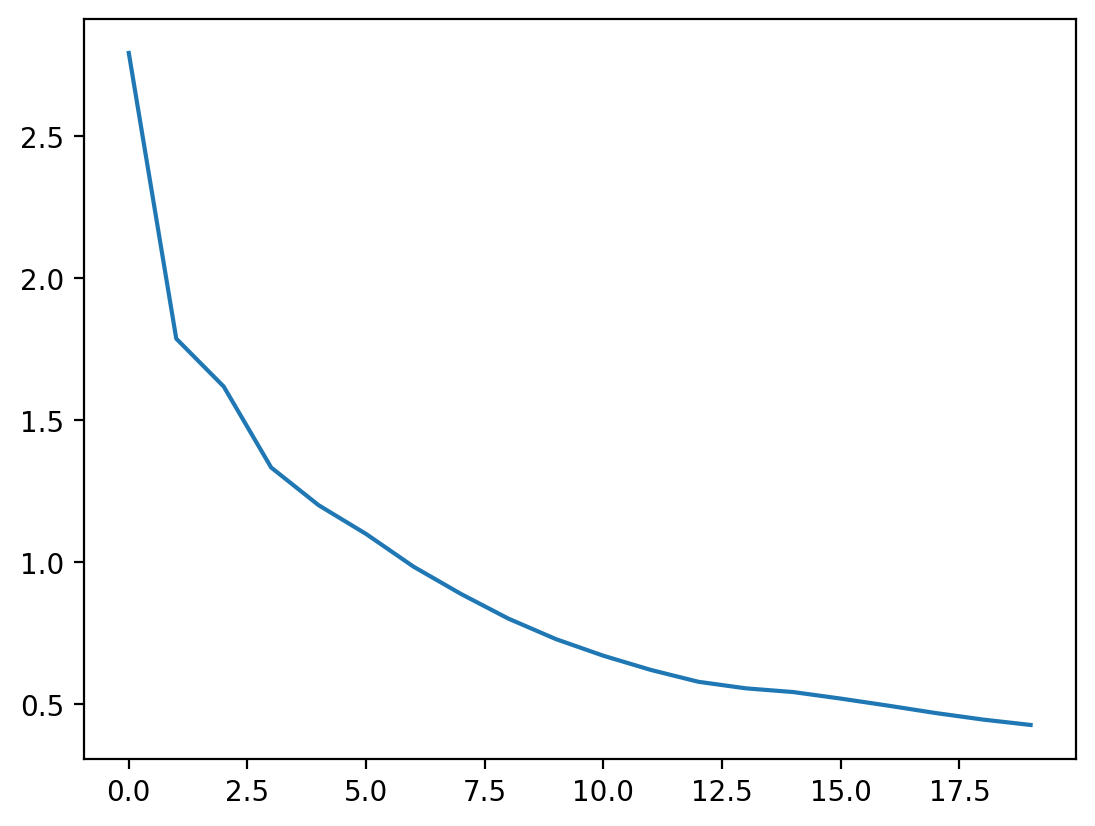

In [5]:
plt.plot(epoch_loss)

In [6]:
output_states = [torch.squeeze(x[0], 0) for x in outputs]
[x.shape for x in output_states]

[torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128])]

Text(0.5, 1.0, 'Final prediction by epoch')

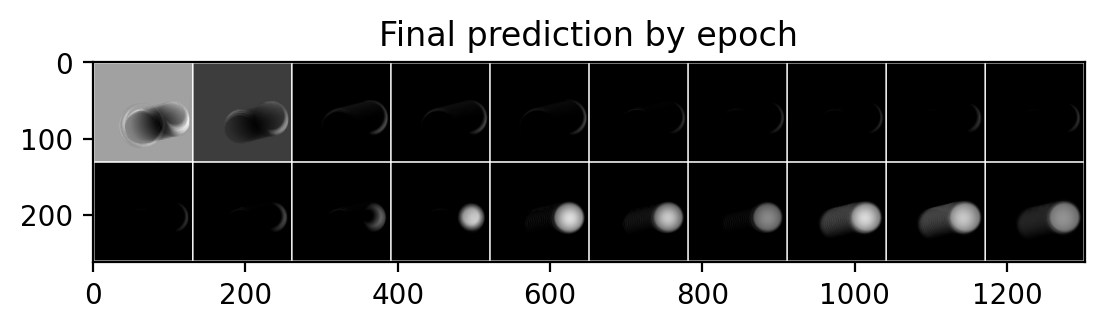

In [7]:
plt.imshow(
    torchvision.utils.make_grid(output_states, nrow=10, normalize=True, pad_value=1).permute(1,2,0)
)
plt.title("Final prediction by epoch")

Text(0.5, 1.0, 'Blob state over time')

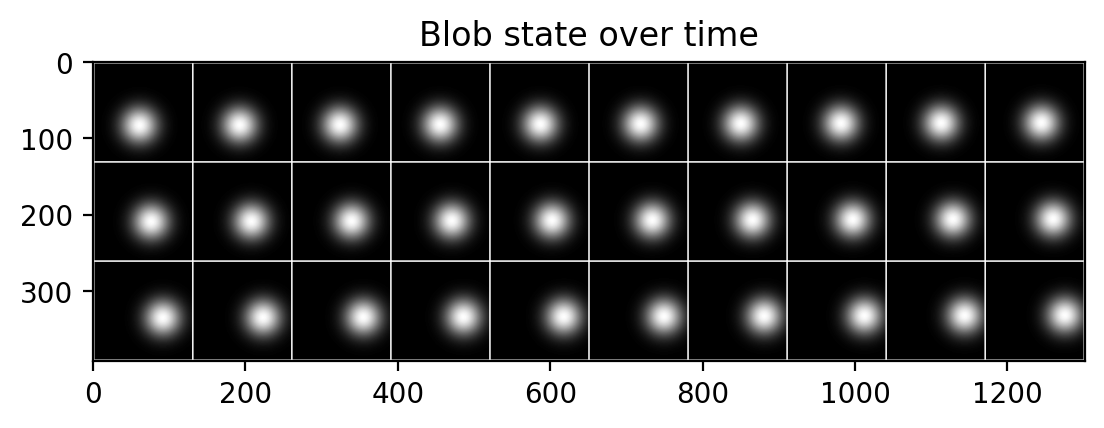

In [8]:
blob, blob_tensor, _, _, final_state, video_id = traindata.__getitem__(2)
video_id

plt.imshow(
    torchvision.utils.make_grid(blob, nrow=10, normalize=True, pad_value=1).permute(1,2,0)
)
plt.title("Blob state over time")

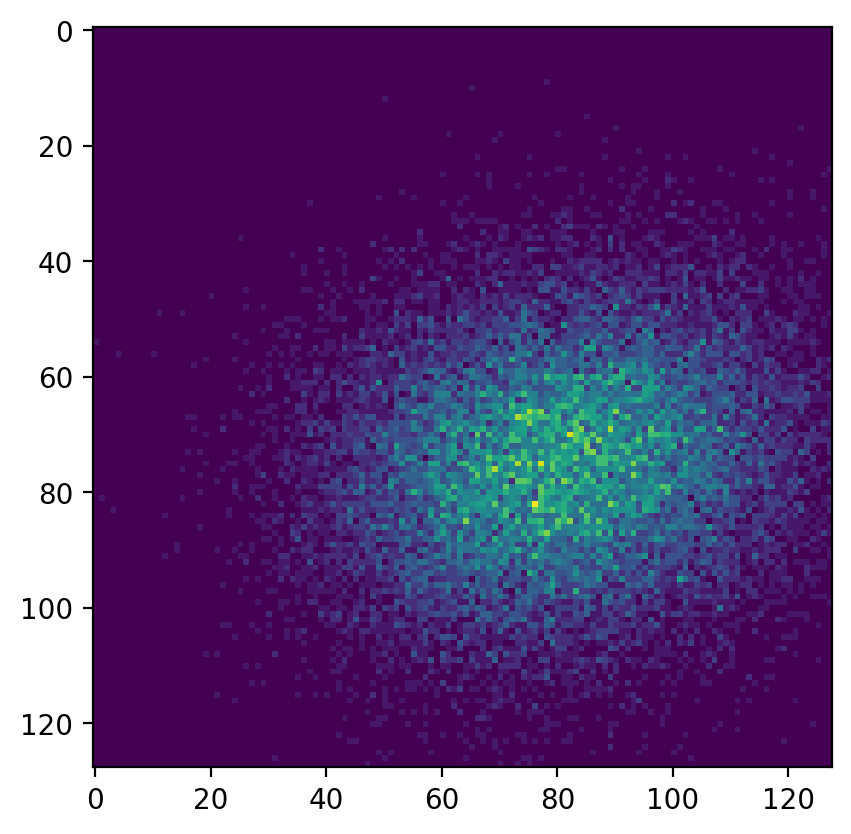

In [9]:
plt.imshow(final_state.permute(1,2,0))

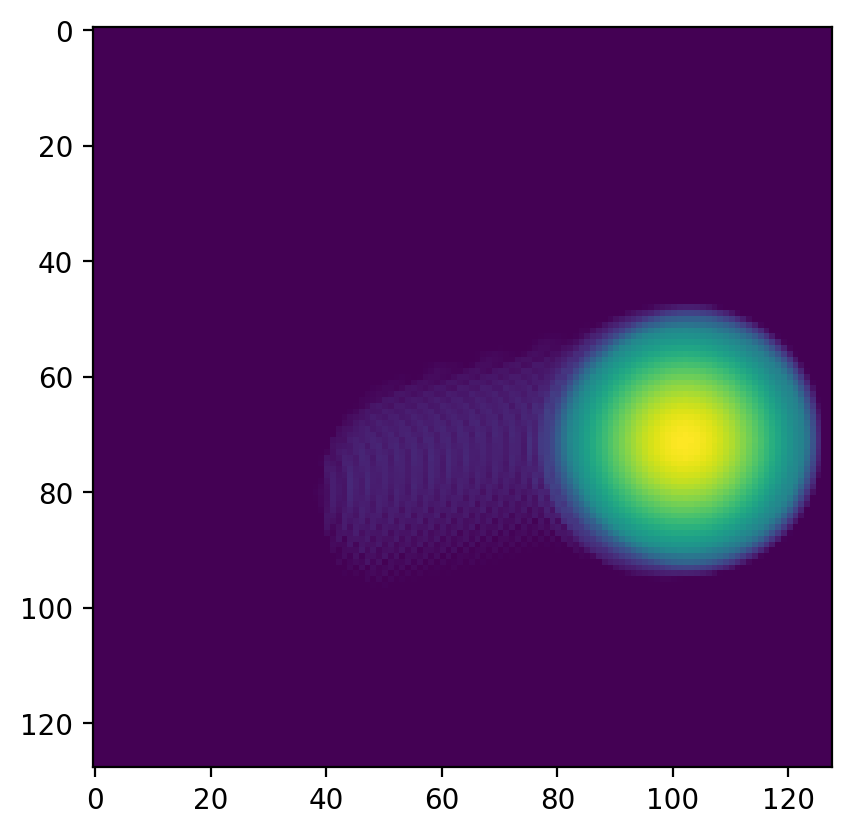

In [10]:
prediction, stem_result, encoding, encoding_prediction, upsample, output_video, avgpool = net(torch.unsqueeze(blob_tensor,0).to('cuda'))
plt.imshow(torch.squeeze(prediction,0).cpu().detach().permute(1,2,0))

In [11]:
def test():
    # net.eval()
    testdata = CustomVideoDataset(
        file_df.query("train == 0"), VIDEO_DIR, transform_img
    )
    test_dataloader  = DataLoader(testdata,  batch_size=12, shuffle=True)

    blob, blob_tensor, claims, claims_tensor, final_state, video_id  = next(iter(test_dataloader))

    blob_tensor = blob_tensor.to("cuda")
    final_state = final_state.to("cuda")
    output_tensor, _, _, _, _, _, _ = net(blob_tensor)
    output_tensor = output_tensor.cpu().detach()
    return final_state, output_tensor

final_state, output_tensor = test()
gc.collect()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


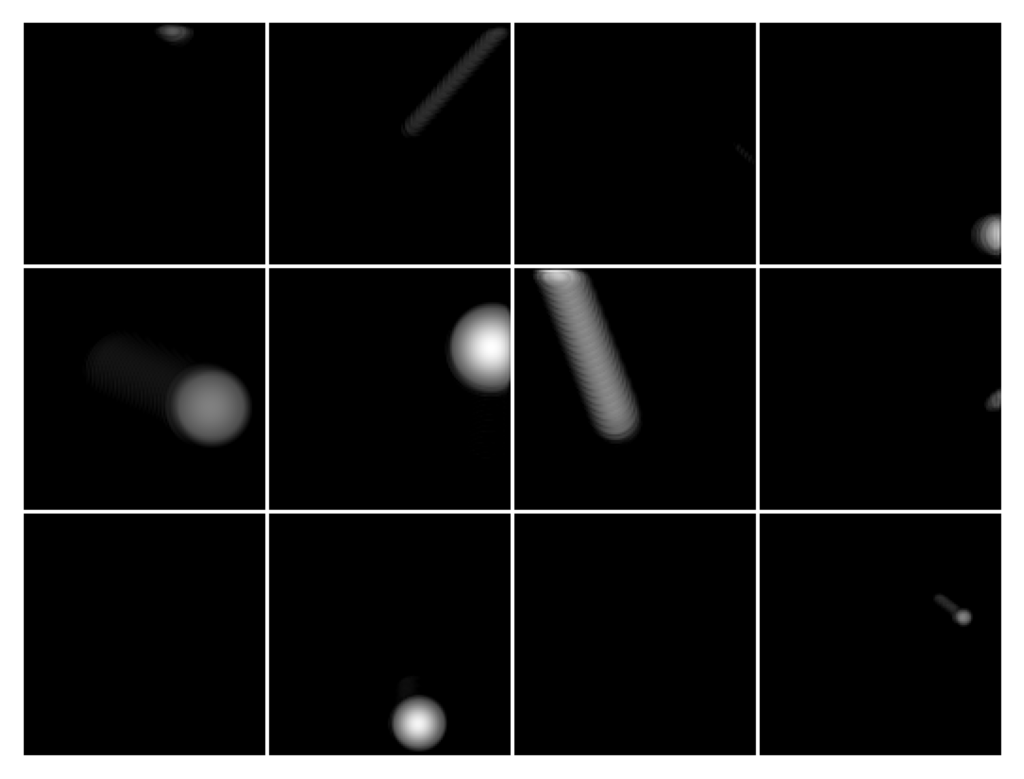

In [12]:
plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


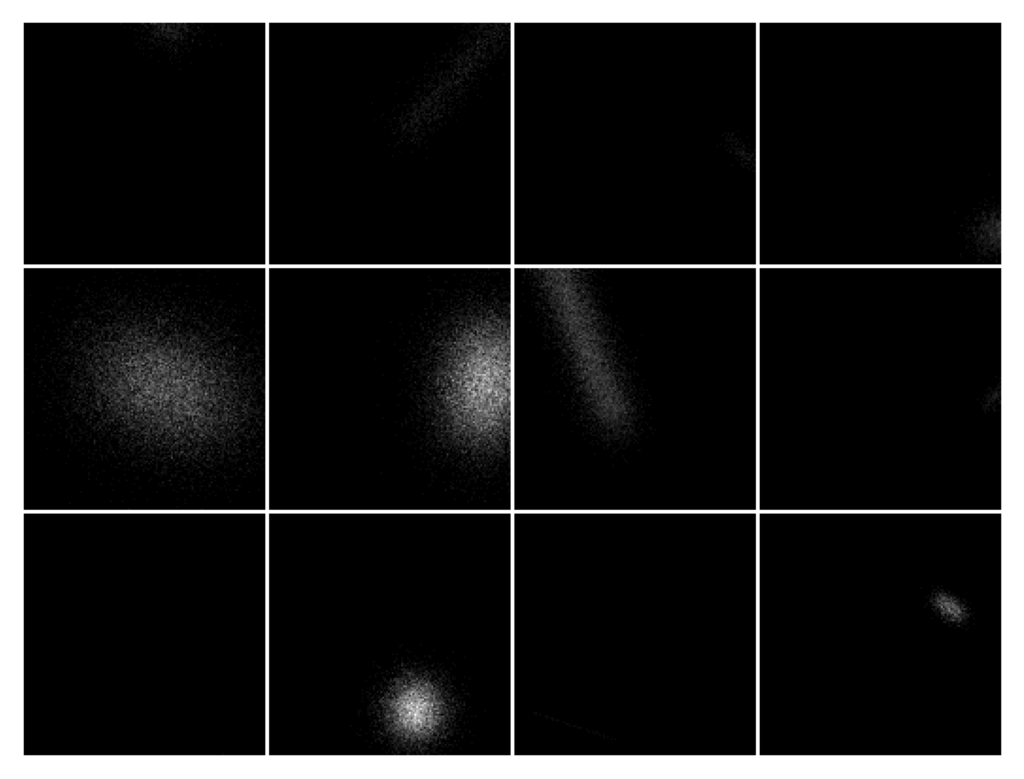

In [13]:
plt.imshow(
    torchvision.utils.make_grid(final_state.cpu().detach(), nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

In [14]:
print((final_state * 255).sum())
print((output_tensor * 255).sum())

tensor(57111., device='cuda:0')
tensor(29800.9688)


In [15]:
# Full test error
def test():
    testdata = CustomVideoDataset(
        file_df.query("train == 0"), VIDEO_DIR, transform_img
    )
    test_dataloader = DataLoader(testdata, batch_size = 1)
    test_loss = []
    for _, data in enumerate(test_dataloader):
        _, blob_tensor, _, _, final_state, video_id = data
        blob_tensor = blob_tensor.to("cuda")
        final_state = final_state.to("cuda")
        res = net(blob_tensor)
        output_tensor, _, _, _, _, _, _ = res
        loss_tensor = nn.MSELoss()(
            output_tensor, final_state
        )
        # Average losses
        test_loss.append(loss_tensor.cpu().detach().numpy().tolist())
    gc.collect()
    torch.cuda.empty_cache()
    return np.mean(test_loss)

test()

2.6082308529797392e-05

# Does having more encoding/decoding layers assist?

In [2]:
class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution"""

    def __init__(self) -> None:
        super().__init__(
            nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
        )

class VideoResNet3(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_makers: Sequence[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]],
        layers: List[int],
        stem: Callable[..., nn.Module],
        zero_init_residual: bool = False,
        verbose: bool = False,
    ) -> None:
        """Generic resnet video generator.

        Args:
            block (Type[Union[BasicBlock, Bottleneck]]): resnet building block
            conv_makers (List[Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]]]): generator
                function for each layer
            layers (List[int]): number of blocks per layer
            stem (Callable[..., nn.Module]): module specifying the ResNet stem.
            ~~num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.~~
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super().__init__()

        self.verbose = verbose

        self.inplanes = 64
        self.stem = stem()
        # Downsamples with the temporal
        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)
        # Back up to original
        self.layer5 = self.double_conv(512+256, 256)
        self.layer6 = self.double_conv(256+128, 128)
        self.layer7 = self.double_conv(128+64, 64)
        self.layer8 = self.double_conv(64+1, 1)
        # Conv outputs for intermediate predictions (pyramid loss)
        self.conv1_output = nn.Conv3d(64, 1, [30,1,1])      # Outputs torch.Size([1, 1, 1, 64, 64]) from torch.Size([1, 64, 30, 64, 64])
        self.conv2_output = nn.Conv3d(128, 1, [15,1,1])     # Outputs torch.Size([1, 1, 1, 32, 32]) from torch.Size([1, 128, 15, 32, 32])
        self.conv3_output = nn.Conv3d(256, 1, [8,1,1])     # Outputs torch.Size([1, 1, 1, 16, 16]) from torch.Size([1, 256, 8, 16, 16])
        self.conv4_output = nn.Conv3d(512, 1, [4,1,1])     # Outputs torch.Size([1, 1, 1, 8, 8]) from torch.Size([1, 512, 4, 8, 8])
        self.avgpool = nn.AdaptiveAvgPool3d((1, 128, 128))
        self.final = nn.ReLU()

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[union-attr, arg-type]

    def print_verbose(self, x):
        if self.verbose:
            print(x)

    def forward(self, x: Tensor) -> Tensor:
        self.print_verbose("Starting")
        # Encoding -------------------------------------------------------------
        self.print_verbose("Layer input " + str(x.shape))
        conv0 = x
        x = self.stem(x)
        self.print_verbose("Layer 0 " + str(x.shape))
        conv1 = x = self.layer1(x)
        conv1_prediction = self.conv1_output(conv1)
        self.print_verbose("Layer 1 " + str(x.shape))
        conv2 = x = self.layer2(x)
        conv2_prediction = self.conv2_output(conv2)
        self.print_verbose("Layer 2 " + str(x.shape))
        conv3 = x = self.layer3(x)
        conv3_prediction = self.conv3_output(conv3)
        self.print_verbose("Layer 3 " + str(x.shape))
        conv4 = x = self.layer4(x)
        conv4_prediction = self.conv4_output(conv4)
        self.print_verbose("Layer 4 " + str(x.shape))

        # Decoding -------------------------------------------------------------
        # Upsample ---------------------------------
        x = nn.Upsample([8, 16, 16], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 5 " + str(x.shape))
        x = torch.cat([x, conv3], dim=1)
        self.print_verbose("Layer 5 " + str(x.shape))
        x = self.layer5(x)
        self.print_verbose("Layer 5 " + str(x.shape))
        # Upsample ---------------------------------
        x = nn.Upsample([15, 32, 32], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 6 " + str(x.shape))
        x = torch.cat([x, conv2], dim=1)
        self.print_verbose("Layer 6 " + str(x.shape))
        x = self.layer6(x)
        self.print_verbose("Layer 6 " + str(x.shape))
        # Upsample ---------------------------------
        x = nn.Upsample([30, 64, 64], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 7 " + str(x.shape))
        x = torch.cat([x, conv1], dim=1)
        self.print_verbose("Layer 7 " + str(x.shape))
        x = self.layer7(x)
        self.print_verbose("Layer 7 " + str(x.shape))
        x = nn.Upsample([30, 128, 128], mode='trilinear', align_corners=True)(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        x = torch.cat([x, conv0], dim=1)
        self.print_verbose("Layer 8 " + str(x.shape))
        x = self.layer8(x)
        self.print_verbose("Layer 8 " + str(x.shape))
        # Final output
        x = self.avgpool(x)
        x = torch.squeeze(x, 2)
        self.print_verbose("After squeeze " + str(x.shape))
        # Make sure the output is in the range 0,Inf
        x = self.final(x)
        return x, conv1_prediction, conv2_prediction, conv3_prediction, conv4_prediction

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        conv_builder: Type[Union[Conv3DSimple, Conv3DNoTemporal, Conv2Plus1D]],
        planes: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion, kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

def model_fit(net, train_dataloader, index, output_dir, epochs):
    model_save = f'videoresnet{index}.pt'
    epoch_loss_save = f'epoch-loss-{index}.pkl'
    outputs_save = f'output-tensors-{index}.pkl'
    items_dir = os.path.join(output_dir, f'outputs-{index}')
    # Downsample function -- just a 2-kernel convolution with weight set to 1 and bias removed.
    def downsample(tensor, n):
        downsample = nn.Conv2d(1, 1, 2, 2, bias=False)
        downsample.weight = torch.nn.Parameter(torch.ones_like(downsample.weight))
        for _ in range(0,n):
            tensor = downsample(tensor)
        return tensor
    if not os.path.isdir(items_dir):
        os.mkdir(items_dir)
    if not model_save in os.listdir(items_dir):
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        train_loss = []
        epoch_loss = []
        outputs = []
        for epoch in tqdm(range(epochs)):
            for _, data in enumerate(train_dataloader):
                _, blob_tensor, _, _, final_state, video_id = data
                blob_tensor = blob_tensor.to("cuda")
                final_state_cuda = final_state.to("cuda")
                optimizer.zero_grad()
                res = net(blob_tensor)
                output_tensor, output1, output2, output3, output4 = res
                loss_tensor = nn.MSELoss()(
                    output_tensor, final_state_cuda
                )
                # Handle loss comparison of intermediate outputs
                intermediate_outputs = [output1, output2, output3, output4]
                for i,v in enumerate(intermediate_outputs):
                    final_state_downsampled = downsample(final_state, i+1)
                    final_state_downsampled = torch.unsqueeze(final_state_downsampled,0) # Match dim of output [1,1,1,64,64]
                    final_state_downsampled = final_state_downsampled.to("cuda")
                    encoding_loss_tensor = nn.MSELoss()(
                        v, final_state_downsampled
                    )
                    loss_tensor = (loss_tensor + encoding_loss_tensor)
                # Average losses
                loss_tensor = loss_tensor / (len(intermediate_outputs)+1)
                loss_tensor.backward()
                train_loss.append(loss_tensor.cpu().detach().numpy().tolist())
                optimizer.step()
                if (video_id == 6):
                    res = tuple(map(lambda x: x.cpu().detach(), res))
                    outputs.append(res)
            epoch_loss_one = np.mean(train_loss)
            epoch_loss.append(epoch_loss_one)

        torch.save(net.state_dict(), os.path.join(items_dir, model_save))
        with open(os.path.join(items_dir, epoch_loss_save), 'wb') as fp:
            pickle.dump(epoch_loss, fp)
        with open(os.path.join(items_dir, outputs_save), 'wb') as fp:
            pickle.dump(outputs, fp)
    else:
        net.load_state_dict(torch.load(os.path.join(items_dir, model_save)))
        net.eval()
        with open (os.path.join(items_dir, epoch_loss_save), 'rb') as fp:
            epoch_loss = pickle.load(fp)
        with open (os.path.join(items_dir, outputs_save), 'rb') as fp:
            outputs = pickle.load(fp)
    return net, epoch_loss, outputs


In [3]:
net = VideoResNet3(BasicBlock, [Conv2Plus1D] * 8, [2, 2, 2, 2], R2Plus1dStem, verbose=False)
net = net.to('cuda')
net, epoch_loss, outputs = model_fit(net, train_dataloader, 5, 'modelsave', 20)

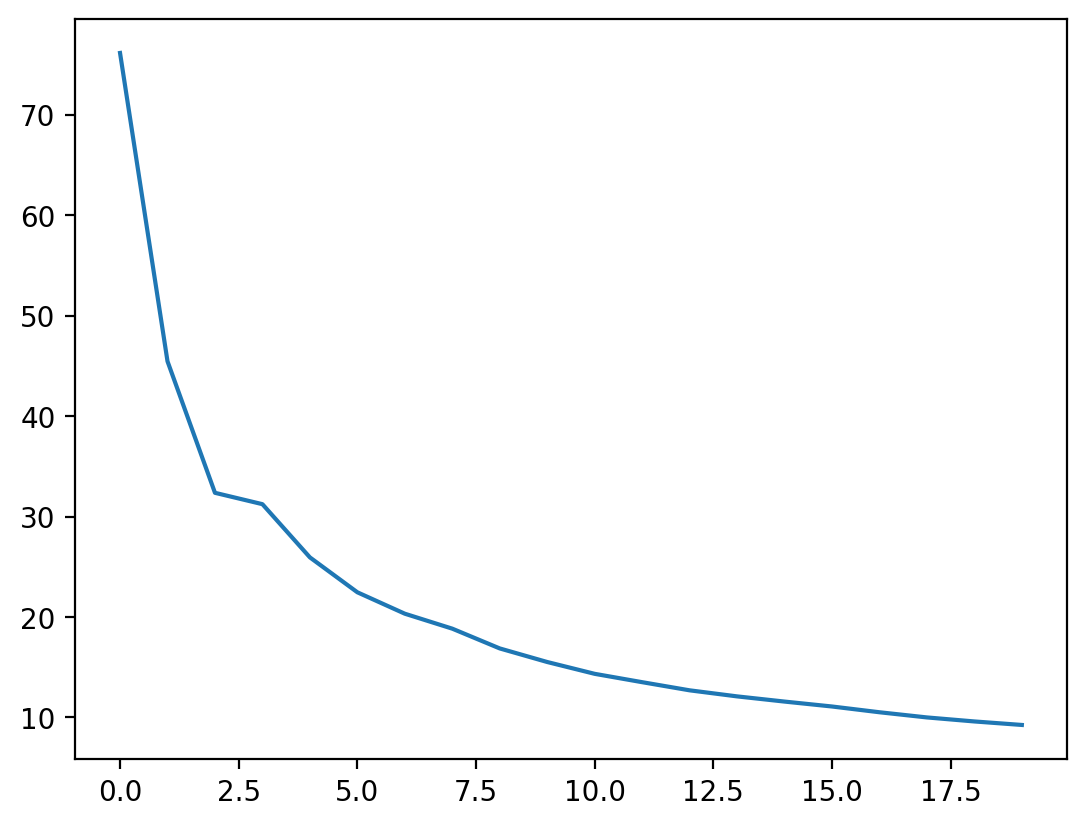

In [4]:
plt.plot(epoch_loss)

Text(0.5, 1.0, 'Final prediction by epoch')

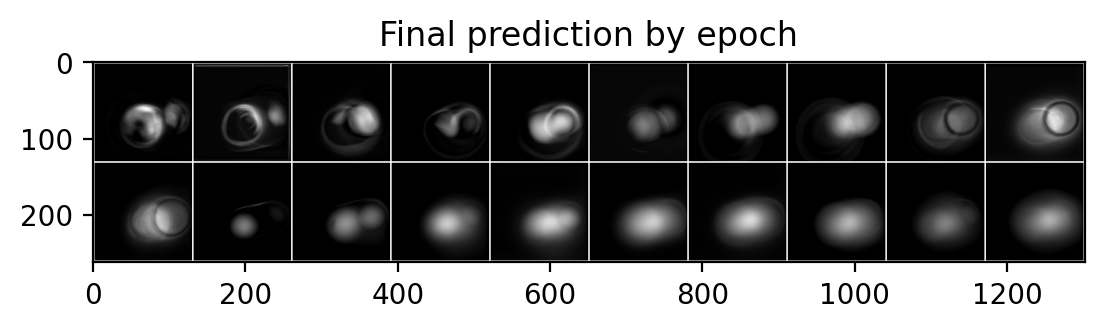

In [5]:
output_states = [torch.squeeze(x[0], 0) for x in outputs]
plt.imshow(
    torchvision.utils.make_grid(output_states, nrow=10, normalize=True, pad_value=1).permute(1,2,0)
)
plt.title("Final prediction by epoch")

Text(0.5, 1.0, 'Blob state over time')

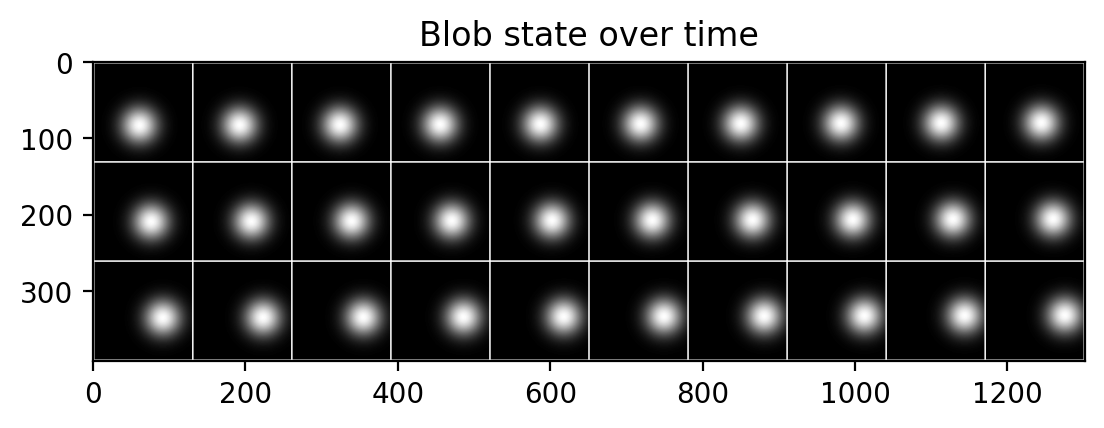

In [6]:
blob, blob_tensor, _, _, final_state, video_id = traindata.__getitem__(2)
video_id

plt.imshow(
    torchvision.utils.make_grid(blob, nrow=10, normalize=True, pad_value=1).permute(1,2,0)
)
plt.title("Blob state over time")

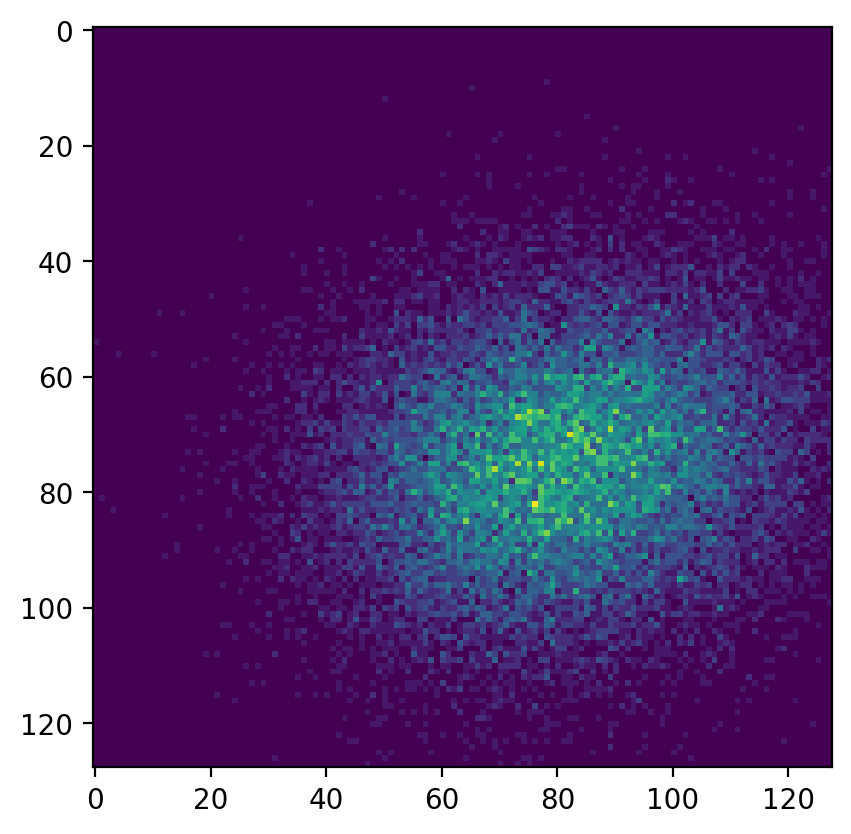

In [7]:
plt.imshow(final_state.permute(1,2,0))

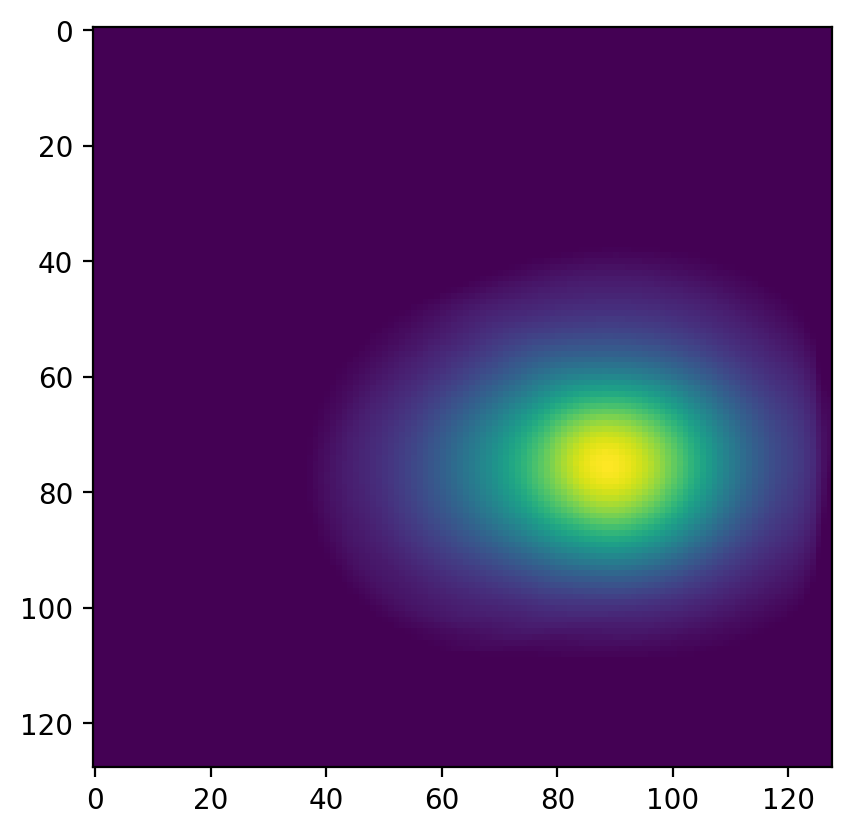

In [8]:
prediction, _, _, _, _ = net(torch.unsqueeze(blob_tensor,0).to('cuda'))
plt.imshow(torch.squeeze(prediction,0).cpu().detach().permute(1,2,0))

In [9]:
gc.collect()
torch.cuda.empty_cache()

In [10]:
def test():
    # net.eval()
    testdata = CustomVideoDataset(
        file_df.query("train == 0"), VIDEO_DIR, transform_img
    )
    test_dataloader  = DataLoader(testdata,  batch_size=12, shuffle=True)

    blob, blob_tensor, claims, claims_tensor, final_state, video_id  = next(iter(test_dataloader))

    blob_tensor = blob_tensor.to("cuda")
    final_state = final_state.to("cuda")
    output_tensor, _, _, _, _ = net(blob_tensor)
    output_tensor = output_tensor.cpu().detach()
    return final_state, output_tensor

final_state, output_tensor = test()
gc.collect()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


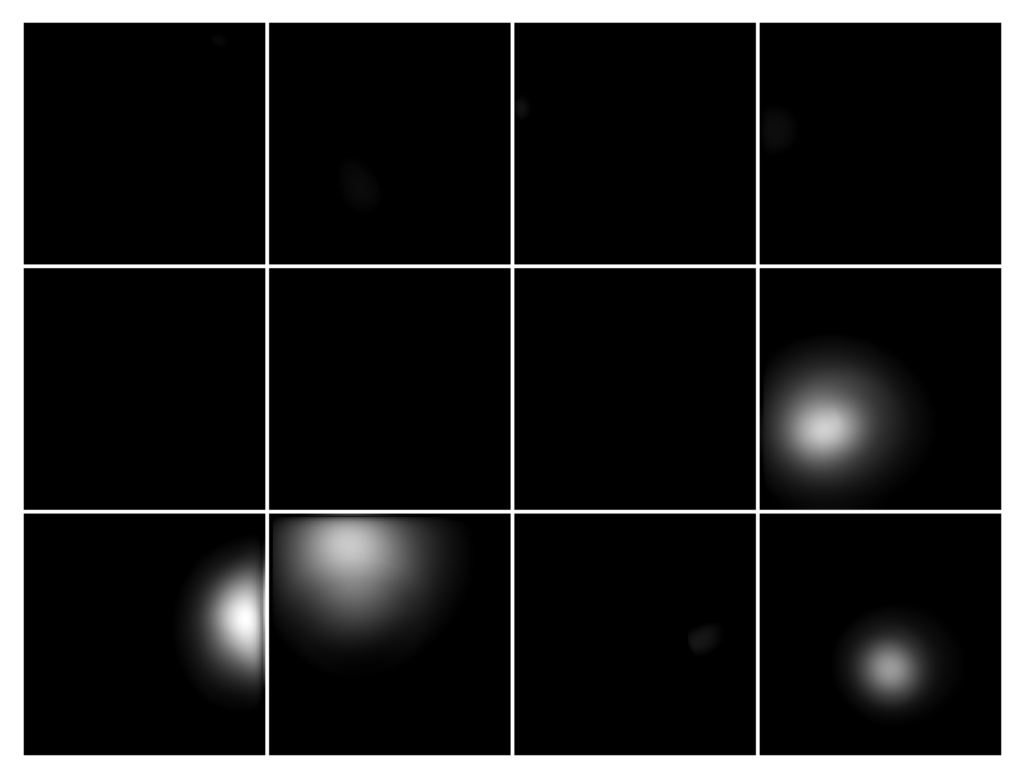

In [11]:
plt.imshow(
    torchvision.utils.make_grid(output_tensor, nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


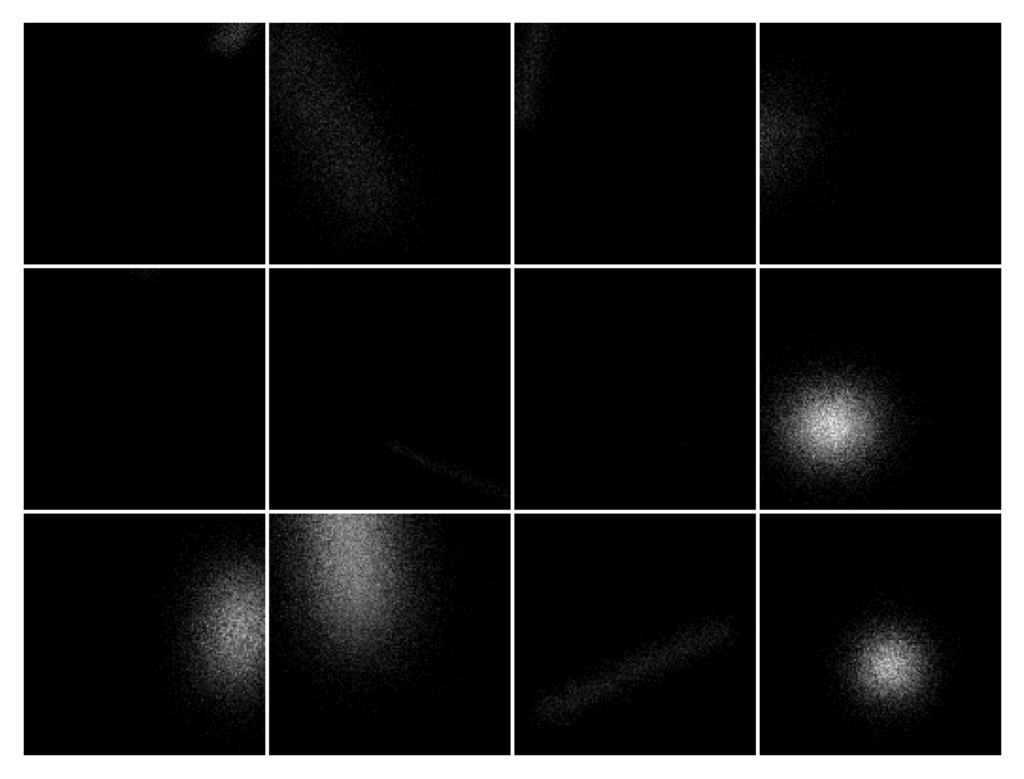

In [12]:
plt.imshow(
    torchvision.utils.make_grid(final_state.cpu().detach(), nrow=4, normalize=True, pad_value=255).permute(1, 2, 0).detach().numpy()
)
plt.axis("off")
plt.show()

In [13]:
print((final_state * 255).sum())
print((output_tensor * 255).sum())

tensor(102945., device='cuda:0')
tensor(72834.0312)


In [15]:
# Full test error
def test():
    testdata = CustomVideoDataset(
        file_df.query("train == 0"), VIDEO_DIR, transform_img
    )
    test_dataloader = DataLoader(testdata, batch_size = 1)
    test_loss = []
    for _, data in enumerate(test_dataloader):
        _, blob_tensor, _, _, final_state, video_id = data
        blob_tensor = blob_tensor.to("cuda")
        final_state = final_state.to("cuda")
        res = net(blob_tensor)
        output_tensor, _, _, _, _ = res
        loss_tensor = nn.MSELoss()(
            output_tensor, final_state
        )
        # Average losses
        test_loss.append(loss_tensor.cpu().detach().numpy().tolist())
    gc.collect()
    torch.cuda.empty_cache()
    return np.mean(test_loss)

test()

1.653345915513986e-05

Test error is indeed smaller than that of the smaller network by a factor of roughly 1.6x, and anecdotally (visually) the output maps appear more like a smooth distribution of values instead of the lumpy results from the preceding network architecture.